# Class mapping 

|Label | prob | type|
|------|------|-----|
|0     | 0.0  | mono|
|1     | 0.333| mono|
|2     | 0.667| mono|
|3     | 1.0  | mono|
|4     | 0.0  | poly|
|5     | 0.333| poly|
|6     | 0.667| poly|
|7     | 1.0  | poly|

In [1]:
from utils.classifier import *
from utils.dataloader import *
from utils.features import *
from utils.helper import *
from utils.processing import *

In [2]:
RANDOM_STATE = 66
ROOT_PATH, DATA_PATH, OUT_PATH = get_paths()
PARAMS = []
print(ROOT_PATH)

/Users/moooooo16/Documents/Computer Vision/Project/elpv


In [4]:
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score

augment_funcs = [flip_x, flip_y, rotate]

preprocess_pipeline = [
    (strech_img, {
        }),
    # (clach_img, {
    #     'clipLimit': 2.0, 
    #     'tileGridSize': (8, 8)}),
    # (guassian_blur, {
    #     'kernel_size': (0, 0), 
    #     'sigmaX': 3}),
    # (lap_feature, {
    #     'dst': -1, 
    #     'ksize' : 5}),
    # (morpo_opening, {
    #     'kernel': np.ones((2,2), np.uint8), 
    #     'iterations': 1}),
]

hog_params = {
    'orient': 10,
    'pix_per_cell': 10,
    'cell_per_block': 1,
    'vis': False,
    # 'block_norm': 'L2-Hys'
}

svm_param = {
    'C': 10,
    'kernel' : 'rbf',
    # 'gamma' : 0.0001,
    # 'class_weight' : 'balanced',
    # 'verbose' : False,
}


grid_svm_params = {
    'svm_param': {
        'kernel': ['rbf'],
        'C' : [10],
        'class_weight': ['balanced']},
    'scoring': {
        "F1_Weighted": make_scorer(f1_score, average='weighted'),
        "Balanced_Accuracy": make_scorer(balanced_accuracy_score),},
    'refit': 'Balanced_Accuracy',
    'verbose' : 3
}


PARAMS.append(augment_funcs)
PARAMS.append(preprocess_pipeline)
PARAMS.append(hog_params)
PARAMS.append(svm_param)
# PARAMS.append(grid_svm_params)

In [9]:
from sklearn.model_selection import train_test_split
img_path, prob, types, labels= load_data(DATA_PATH)

feature_builder = FeatureExtraction(DATA_PATH, img_path, labels)
X_train, X_test, y_train, y_test = feature_builder.split_data(train_test_split, randome_state=RANDOM_STATE, stratify=True, split_ratio=0.25)

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]
2624 2624 2624 2624


In [10]:
X_train_aug, y_train_aug = feature_builder.augmentation(X_train, y_train, augment_funcs=augment_funcs)

X_train_prepro = feature_builder.preprocess(X_train_aug, preprocess_pipeline = preprocess_pipeline)
X_test_prepro = feature_builder.preprocess(X_test, preprocess_pipeline = preprocess_pipeline)

print(X_train_prepro.shape, y_train_aug.shape)
print(X_test_prepro.shape, y_test.shape)

(1968, 300, 300) (1968,)
(656, 300, 300) (656,)


In [11]:
train_hog_des = feature_builder.get_hog_features(X_train_prepro, **hog_params)
test_hog_des = feature_builder.get_hog_features(X_test_prepro, **hog_params)

print(train_hog_des.shape)
print(test_hog_des.shape)

Augmenting images: 100%|██████████| 1968/1968 [00:00<00:00, 72735.52it/s]

Augmenting done, added image: 900
(2868, 300, 300) (2868,)
(656, 300, 300) (656,)


Pre-processing images: 100%|██████████| 656/656 [00:00<00:00, 1705.63it/s]


(2868, 300, 300) (2868,)
(656, 300, 300) (656,)


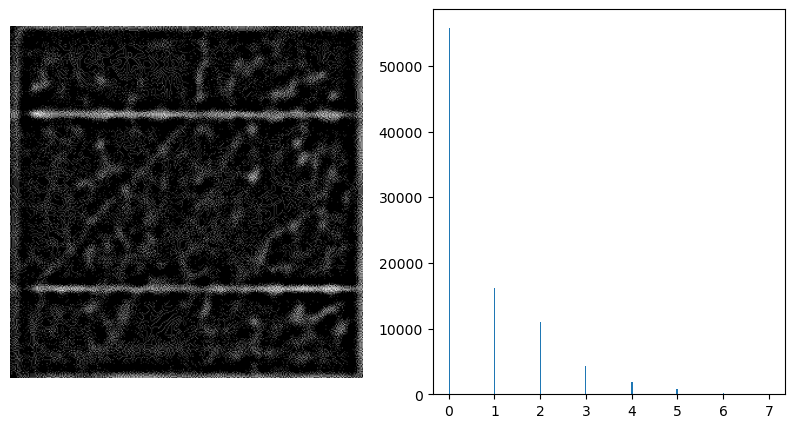

In [22]:
from sklearn.svm import SVC

best_clf = SVC(**svm_param).fit(train_hog_des, y_train_aug)

pred = best_clf.predict(test_hog_des)

acc, conf_mat = get_report(y_test, pred)

print()
print(f'Overall Test Accuracy: {acc:.2f}')
print(f'Confusion Matrix: \n{conf_mat}')
print('-'*100)


In [16]:
PARAMS

[[<function utils.processing.flip_x(img)>,
  <function utils.processing.flip_y(img)>,
  <function utils.processing.rotate(img)>],
 [(<function utils.processing.clach_img(img, clipLimit, tileGridSize)>,
   {'clipLimit': 2.0, 'tileGridSize': (8, 8)}),
  (<function utils.processing.guassian_blur(img, kernel_size, sigmaX)>,
   {'kernel_size': (0, 0), 'sigmaX': 3}),
  (<function utils.processing.lap_feature(img, dst, ksize)>,
   {'dst': -1, 'ksize': 5}),
  (<function utils.processing.morpo_opening(img, kernel, iterations)>,
   {'kernel': array([[1, 1],
           [1, 1]], dtype=uint8),
    'iterations': 1})],
 {'orient': 9,
  'pix_per_cell': 10,
  'cell_per_block': 1,
  'vis': False,
  'block_norm': 'L2-Hys'},
 {'C': 5,
  'kernel': 'rbf',
  'gamma': 0.0001,
  'class_weight': 'balanced',
  'verbose': True}]